In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import os
import DataLoad
import ImagePreprocessor
import Labeling
import TrajectoryPhy
import umap

report_path = 'result/report_all.csv'

2023-01-21 20:33:11.121714: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
header, data = DataLoad.read_report(report_path)
print(header)
print(data[0])

['filename', 'id', 'class_id', 'class_name', 'probability', 'maximum_radius', 'first_x_position', 'first_y_position']
{'filename': '20220301_H2B Halo_Field3_no_ir001', 'id': '2', 'class_id': '0', 'class_name': 'Immobile', 'probability': '0.9990927', 'maximum_radius': '0.08163692542593697', 'first_x_position': '12.683669', 'first_y_position': '12.079526'}


In [36]:
max_rs_immobile = np.array(list([float(x['maximum_radius']) for x in data if x['class_id']=='0']))
max_rs_hybrid = np.array(list([float(x['maximum_radius']) for x in data if x['class_id']=='1']))
max_rs_mobile = np.array(list([float(x['maximum_radius']) for x in data if x['class_id']=='2']))

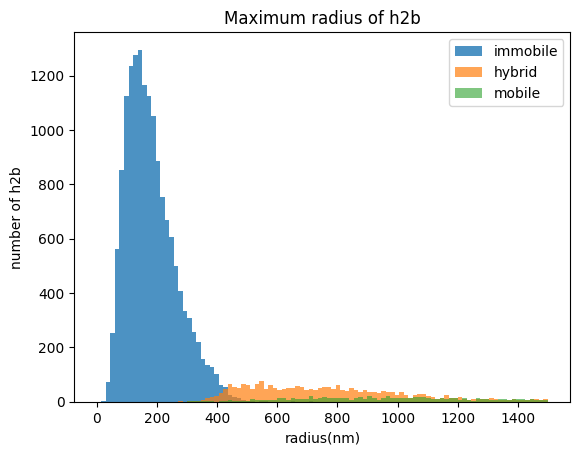

In [43]:
plt.figure()
plt.title('Maximum radius of h2b')
plt.hist(max_rs_immobile*1000, range = (0, 1500), bins = 100, alpha=0.8, label='immobile')
plt.hist(max_rs_hybrid*1000, range = (0, 1500), bins = 100, alpha=0.7, label='hybrid')
plt.hist(max_rs_mobile*1000, range = (0, 1500), bins = 100, alpha=0.6, label='mobile')
plt.xlabel('radius(nm)')
plt.ylabel('number of h2b')
plt.legend()
plt.show()